In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import math
from imblearn.over_sampling import SMOTE,ADASYN
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from scipy.stats import ttest_1samp
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,roc_auc_score, confusion_matrix, classification_report,precision_score,recall_score,plot_roc_curve,log_loss
from sklearn import metrics
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, RandomizedSearchCV

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cmpe-257-lab-1-spring-2022/sample_submission.csv
/kaggle/input/cmpe-257-lab-1-spring-2022/x_test.csv
/kaggle/input/cmpe-257-lab-1-spring-2022/y_train.csv
/kaggle/input/cmpe-257-lab-1-spring-2022/x_train.csv
/kaggle/input/cmpe-257-lab-1-spring-2022/Lab 1.pdf


# **Load the Dataset**

In [2]:
train_features = pd.read_csv("/kaggle/input/cmpe-257-lab-1-spring-2022/x_train.csv")
train_output = pd.read_csv("/kaggle/input/cmpe-257-lab-1-spring-2022/y_train.csv")
test_features = pd.read_csv("/kaggle/input/cmpe-257-lab-1-spring-2022/x_test.csv")
ss = pd.read_csv("/kaggle/input/cmpe-257-lab-1-spring-2022/sample_submission.csv")

**Viewing the Head**

In [3]:
ss.head()

,index,target
0,16834,0.494894
1,15437,0.133882
2,8549,0.877003
3,7222,0.813989
4,17054,0.701272


In [4]:
train_features.head()

,index,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
0,17007,city_61,0.913,Male,Has relevent experience,no_enrollment,Masters,STEM,4,100-500,NGO,1,22
1,631,city_94,0.698,Male,Has relevent experience,NaN,High School,NaN,3,NaN,NaN,1,22
2,669,city_114,0.926,NaN,Has relevent experience,Full time course,Masters,STEM,9,50-99,Pvt Ltd,1,88
3,8949,city_114,0.926,Male,No relevent experience,Full time course,Graduate,STEM,14,NaN,NaN,4,91
4,2341,city_16,0.910,NaN,Has relevent experience,no_enrollment,Graduate,STEM,1,5000-9999,Pvt Ltd,1,92


# Summarize the dataset
**a. Number of columns and rows present**

In [5]:
train_features.shape

(14368, 13)

In [6]:
test_features.shape

(4790, 13)

There are 14368 Rows and 13 Columns

**Min, max, avg, std dev etc. stats for continuous features**

In [7]:
train_features.iloc[:,1:].describe()

,city_development_index,training_hours
count,14368.000000,14368.000000
mean,0.828252,65.396645
std,0.123419,60.277583
min,0.448000,1.000000
25%,0.738000,23.000000
50%,0.899000,47.000000
75%,0.920000,88.000000
max,0.949000,336.000000


Above we found the details for each column after the index column

**Number of unique values for categorical features**

In [8]:
train_features.nunique()

index                     14368
city                        123
city_development_index       93
gender                        3
relevent_experience           2
enrolled_university           3
education_level               5
major_discipline              6
experience                   22
company_size                  8
company_type                  6
last_new_job                  6
training_hours              241
dtype: int64

Above we found the number of unique features for each columns

**Number of nulls and Nans in each column**

In [9]:
train_features.isnull().sum()

index                        0
city                         0
city_development_index       0
gender                    3393
relevent_experience          0
enrolled_university        292
education_level            338
major_discipline          2089
experience                  45
company_size              4430
company_type              4598
last_new_job               327
training_hours               0
dtype: int64

Above we have the number of NULL values in each column.

**Visualize distribution of each feature using graphs**

In [10]:
train_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14368 entries, 0 to 14367
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   index                   14368 non-null  int64  
 1   city                    14368 non-null  object 
 2   city_development_index  14368 non-null  float64
 3   gender                  10975 non-null  object 
 4   relevent_experience     14368 non-null  object 
 5   enrolled_university     14076 non-null  object 
 6   education_level         14030 non-null  object 
 7   major_discipline        12279 non-null  object 
 8   experience              14323 non-null  object 
 9   company_size            9938 non-null   object 
 10  company_type            9770 non-null   object 
 11  last_new_job            14041 non-null  object 
 12  training_hours          14368 non-null  int64  
dtypes: float64(1), int64(2), object(10)
memory usage: 1.4+ MB


**Distribution of Categorical Data**

In [11]:
train_features.describe(include=['O'])

,city,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job
count,14368,10975,14368,14076,14030,12279,14323,9938,9770,14041
unique,123,3,2,3,5,6,22,8,6,6
top,city_103,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,50-99,Pvt Ltd,1
freq,3229,9914,10385,10366,8679,10925,2425,2301,7410,6020


In [12]:
categorical_variable = ["gender","relevent_experience","enrolled_university","education_level","major_discipline","experience","company_size","company_type","last_new_job"]

In [13]:
def categorical_plot(v):
    feat = train_features[v]
    feat_count = feat.value_counts()
    plt.figure(figsize = (9,3))
    plt.bar(feat_count.index,feat_count)
    plt.xticks(feat_count.index,feat_count.index.values)
    plt.ylabel("Frequency")
    plt.title(v)
    plt.show()

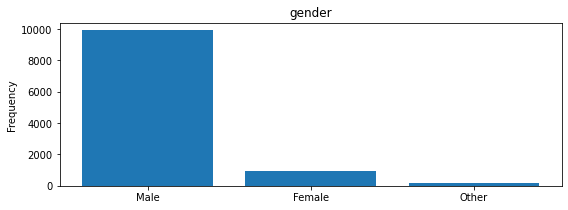

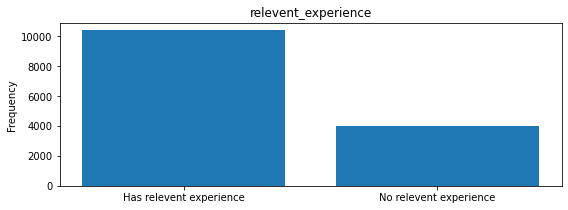

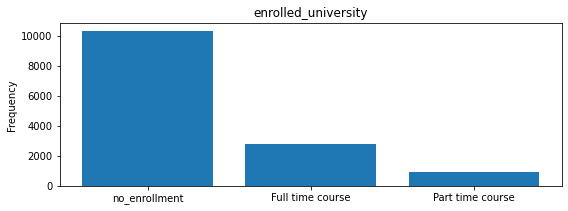

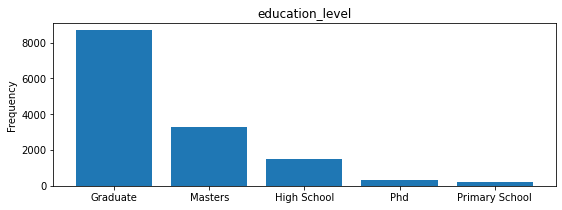

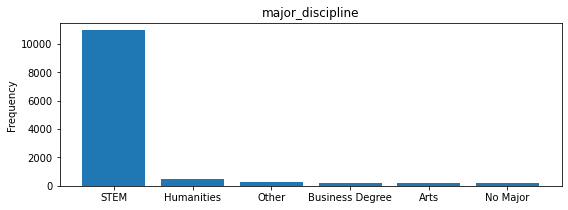

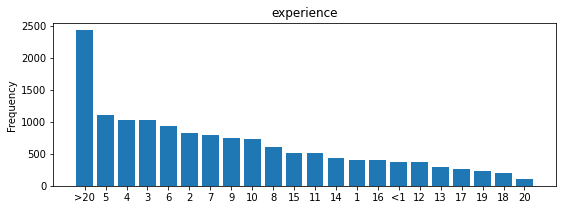

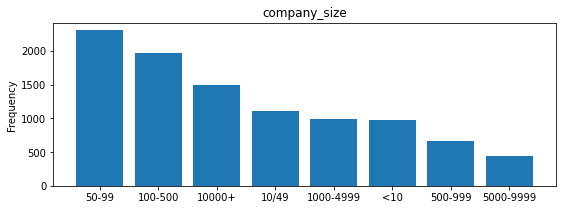

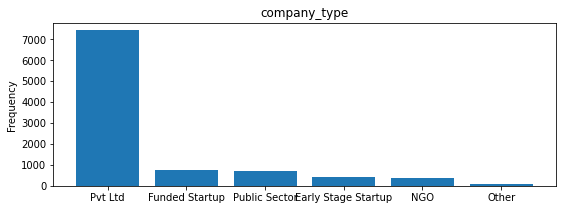

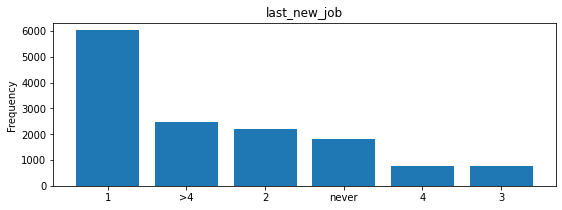

In [14]:
for i in categorical_variable:
    categorical_plot(i)

**Distribution of Numeric data**

In [15]:
def categorical_plot2(v):
    feat = test_features[v]
    feat_count = feat.value_counts()
    plt.figure(figsize = (9,3))
    plt.bar(feat_count.index,feat_count)
    plt.xticks(feat_count.index,feat_count.index.values)
    plt.ylabel("Frequency")
    plt.title(v)
    plt.show()

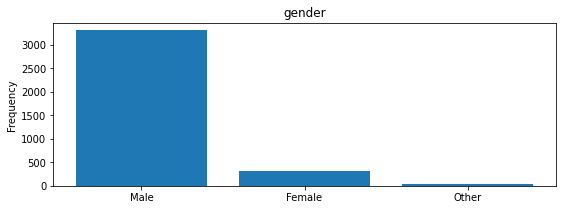

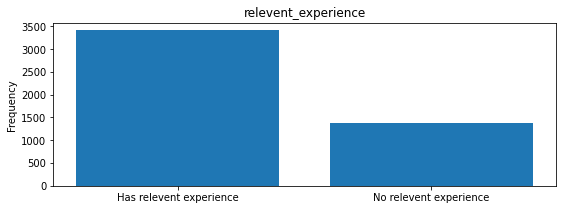

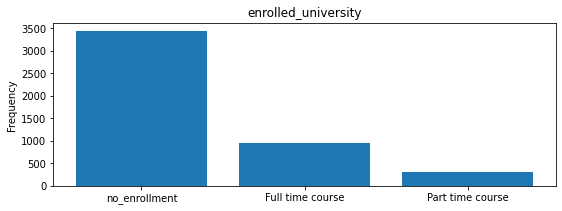

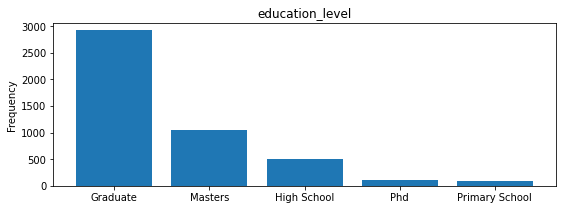

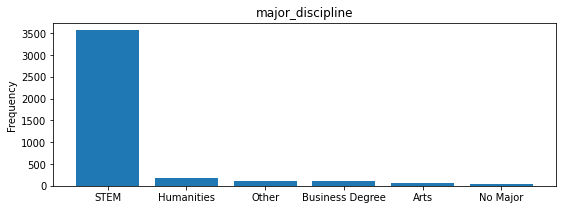

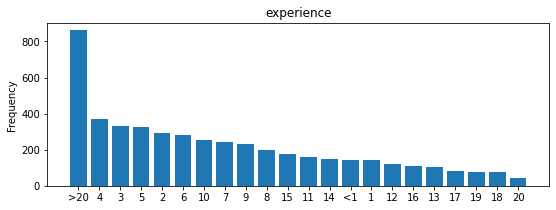

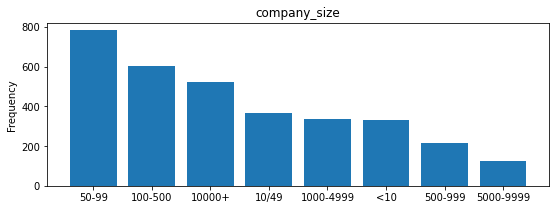

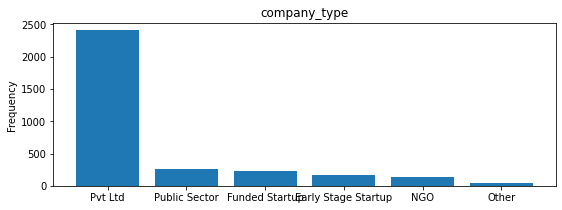

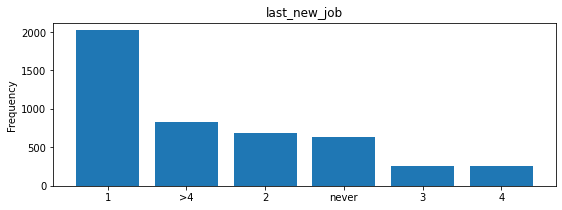

In [16]:
for i in categorical_variable:
    categorical_plot2(i)

In [17]:
def numeric_plot(v):
    plt.figure(figsize = (9,3))
    plt.hist(train_features[v],bins = 50)
    plt.xlabel(v)
    plt.ylabel("Frequency")
    plt.title("{} distribution with hist".format(v))
    plt.show()

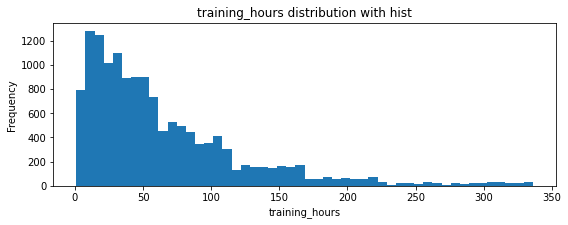

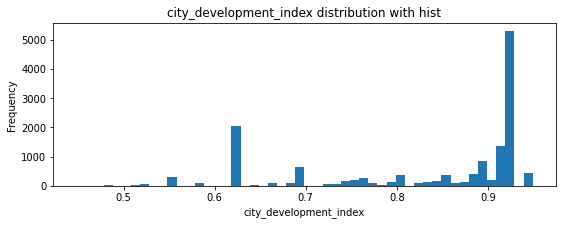

In [18]:
numeric_col = ["training_hours","city_development_index"]
for i in numeric_col:
    numeric_plot(i)

**Plotting city**

<function matplotlib.pyplot.show(close=None, block=None)>

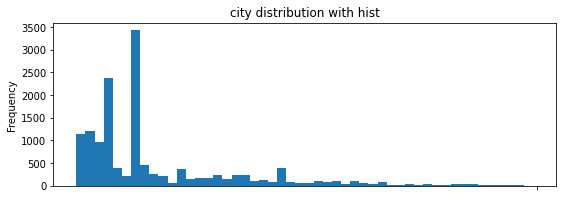

In [19]:
plt.figure(figsize = (9,3))
plt.hist(train_features["city"],bins = 50)
plt.ylabel("Frequency")
plt.xticks("city", " ")
plt.title("{} distribution with hist".format("city"))
plt.show

# **Visualize the relationship of each feature with target variable**

**Adding Class to the train_features**

In [20]:
train_df = pd.concat([train_features, train_output['target']],axis = 1)
train_df.head()

,index,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,17007,city_61,0.913,Male,Has relevent experience,no_enrollment,Masters,STEM,4,100-500,NGO,1,22,0.0
1,631,city_94,0.698,Male,Has relevent experience,NaN,High School,NaN,3,NaN,NaN,1,22,1.0
2,669,city_114,0.926,NaN,Has relevent experience,Full time course,Masters,STEM,9,50-99,Pvt Ltd,1,88,0.0
3,8949,city_114,0.926,Male,No relevent experience,Full time course,Graduate,STEM,14,NaN,NaN,4,91,0.0
4,2341,city_16,0.910,NaN,Has relevent experience,no_enrollment,Graduate,STEM,1,5000-9999,Pvt Ltd,1,92,0.0


In [21]:
def target_visual(V):
    sns.displot(train_df, x=V, hue='target', kind = "kde")
    

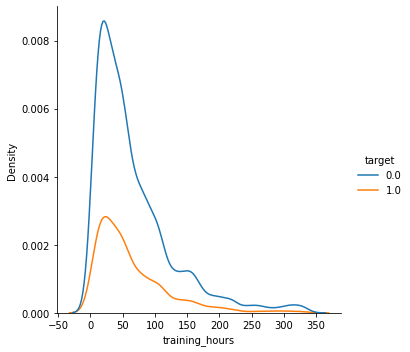

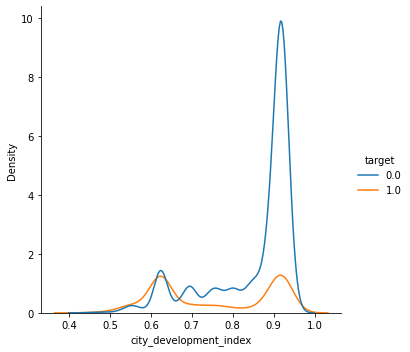

In [22]:
for i in numeric_col:
    target_visual(i)

**Observation**
0 - no job change
1- job change
We see that people who have training hours less than 100 dont want to leave, however the most number of people who want to leave have training hours < 50.

Also People are more comfortanble with their jobs where the city_development index is high.

**Cross Tab for Categorical Features**

In [23]:
def categorical_visual(V):
    pd.crosstab(train_df[V], train_df['target']).plot(kind="bar", stacked="True")

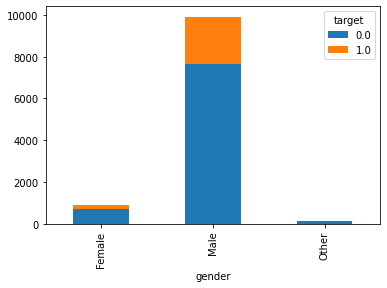

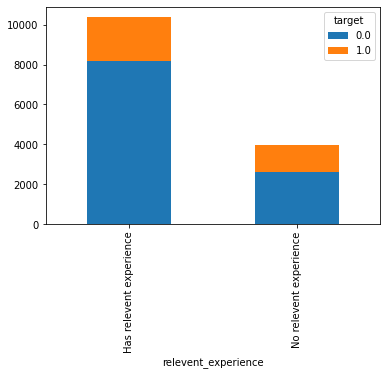

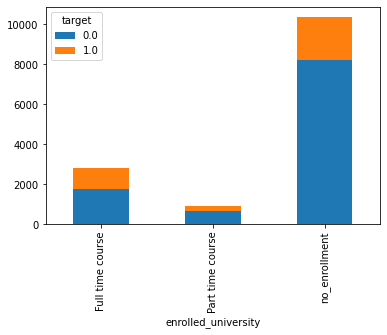

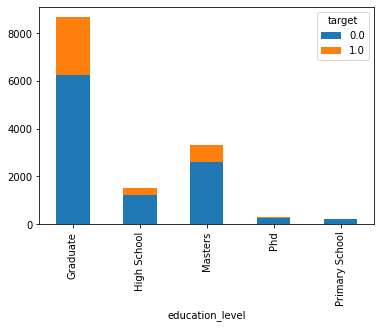

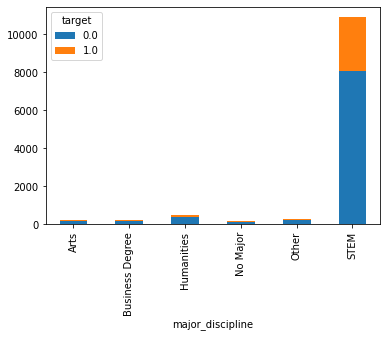

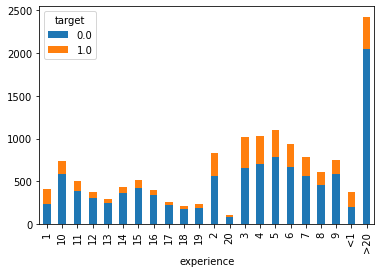

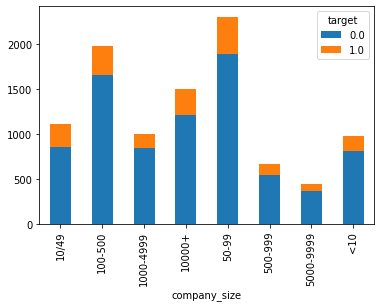

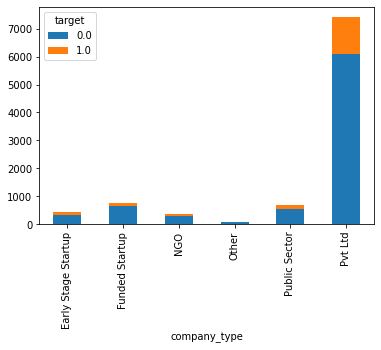

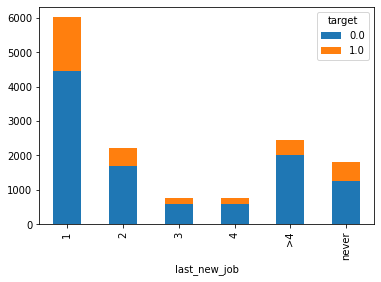

In [24]:
for i in categorical_variable:
    categorical_visual(i)

1) Males gender has a high number of people who want to leave the job.
2) There are more people with relevant experience who want to leave than the people with noe experience.
3) Graduates have a high number of people who are looking for a job change.
4) STEM has high number of people looking for job change.
5) Those who got their job in past 1 year are looking for job change.

<AxesSubplot:xlabel='city'>

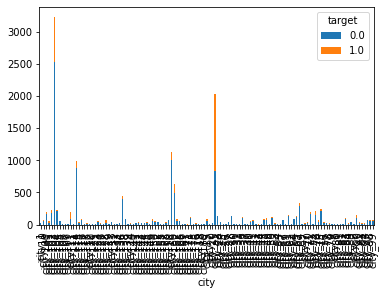

In [25]:
pd.crosstab(train_df['city'], train_df['target']).plot(kind="bar", stacked="True")

# **Handle missing values: Use any three methods to handle missing values.**

In [26]:
train_df1 = train_df.copy(deep = True)
train_df2 = train_df.copy(deep = True)
train_df3 = train_df.copy(deep = True)
train_df4 = train_df.copy(deep = True)
train_df5 = train_df.copy(deep = True)

test_df1 = test_features.copy(deep=True)
test_df2 = test_features.copy(deep=True)
test_df3 = test_features.copy(deep=True)
test_df4 = test_features.copy(deep=True)
test_df5 = test_features.copy(deep=True)

In [27]:
train_df.nunique().sum()

14888

In [28]:
test_df3.shape

(4790, 13)

**1) First way is to drop the rows having null**

In [29]:
train_df1.dropna(inplace=True)
test_df1.dropna(inplace = True)

In [30]:
train_df1.isna().sum()

index                     0
city                      0
city_development_index    0
gender                    0
relevent_experience       0
enrolled_university       0
education_level           0
major_discipline          0
experience                0
company_size              0
company_type              0
last_new_job              0
training_hours            0
target                    0
dtype: int64

In [31]:
test_df1.isna().sum()

index                     0
city                      0
city_development_index    0
gender                    0
relevent_experience       0
enrolled_university       0
education_level           0
major_discipline          0
experience                0
company_size              0
company_type              0
last_new_job              0
training_hours            0
dtype: int64

**2) In second step we can convert the categorical columns to numeric and then replace them with average of that column**

**To convert the categorical columns to numeric we can declare a function, which returns a value for each**

In [32]:
all_exp = set()
exp_dict = {}
def numeric_experience_dict():
    k=1
    for i in train_df2['experience']:
        if i=='>20':
            exp_dict[i]= 21
            all_exp.add(i)
        elif i=='<1':
            exp_dict[i]= 0
            all_exp.add(i)
        elif math.isnan(float(i)):
            continue
        elif i in all_exp:
            continue
        else:
            exp_dict[i]= int(i)
            all_exp.add(i)
numeric_experience_dict()

#print(train_df2['experience'])

exp_dict

{'4': 4,
 '3': 3,
 '9': 9,
 '14': 14,
 '1': 1,
 '17': 17,
 '>20': 21,
 '12': 12,
 '11': 11,
 '13': 13,
 '20': 20,
 '7': 7,
 '6': 6,
 '15': 15,
 '8': 8,
 '19': 19,
 '2': 2,
 '10': 10,
 '5': 5,
 '16': 16,
 '<1': 0,
 '18': 18}

In [33]:
train_df2

,index,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,17007,city_61,0.913,Male,Has relevent experience,no_enrollment,Masters,STEM,4,100-500,NGO,1,22,0.0
1,631,city_94,0.698,Male,Has relevent experience,NaN,High School,NaN,3,NaN,NaN,1,22,1.0
2,669,city_114,0.926,NaN,Has relevent experience,Full time course,Masters,STEM,9,50-99,Pvt Ltd,1,88,0.0
3,8949,city_114,0.926,Male,No relevent experience,Full time course,Graduate,STEM,14,NaN,NaN,4,91,0.0
4,2341,city_16,0.910,NaN,Has relevent experience,no_enrollment,Graduate,STEM,1,5000-9999,Pvt Ltd,1,92,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14363,16304,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,>4,157,0.0
14364,79,city_103,0.920,Female,Has relevent experience,no_enrollment,Masters,STEM,2,<10,Early Stage Startup,1,4,0.0
14365,12119,city_21,0.624,Male,Has relevent experience,no_enrollment,Masters,STEM,1,50-99,Pvt Ltd,NaN,34,0.0
14366,14147,city_10,0.895,Male,Has relevent experience,no_enrollment,Masters,STEM,15,100-500,Public Sector,1,4,0.0


In [34]:
all_city = set()
city_dict = {}
def numeric_experience_city():
    k=1
    for i in train_df2['city']:
        if i in all_city:
            continue
        else:
            city_dict[i]=k
            k+=1
            all_city.add(i)
numeric_experience_city()
print(city_dict['city_104'])

56


In [35]:
def numeric_gender(x):
    if x=='Female': return 2
    if x=='Male':   return 1
    if x=='Other':   return 3
    
def numeric_relevant_experience(x):
    if x=='Has relevent experience': return 1
    if x=='No relevent experience':   return 0
    
def numeric_enrollment(x):
    if x=='no_enrollment'   : return 1
    if x=='Full time course':   return 3 
    if x=='Part time course':   return 2
    
def numeric_education(x):
    if x=='Graduate'       :   return 3
    if x=='Masters'        :   return 4 
    if x=='High School'    :   return 2 
    if x=='Phd'            :   return 5 
    if x=='Primary School' :   return 1 
    
def numeric_major(x):
    if x=='STEM'                   :   return 1
    if x=='Business Degree'        :   return 2 
    if x=='Arts'                   :   return 3 
    if x=='Humanities'             :   return 4 
    if x=='No Major'               :   return 5 
    if x=='Other'                  :   return 6 
    
def numeric_experience(x):
    if x=='>20':
        return exp_dict[x]
    elif x=='<1':
        return exp_dict[x]
    if math.isnan(float(x)) == False:
        return exp_dict[x]

def numeric_companytype(x):
    if x=='Pvt Ltd'               :   return 1
    if x=='Funded Startup'        :   return 2 
    if x=='Early Stage Startup'   :   return 3 
    if x=='Other'                 :   return 4 
    if x=='Public Sector'         :   return 5 
    if x=='NGO'                   :   return 6 
    
def numeric_companysize(x):
    if x=='<10'          :   return 1
    if x=='10/49'        :   return 2 
    if x=='50-99'        :   return 3 
    if x=='100-500'      :   return 4 
    if x=='500-999'      :   return 5 
    if x=='1000-4999'    :   return 6 
    if x=='5000-9999'    :   return 7
    if x=='10000+'       :   return 8 

def numeric_lastjob(x):
    if x=='never'        :   return 1
    if x=='1'            :   return 2 
    if x=='2'            :   return 3 
    if x=='3'            :   return 4 
    if x=='4'            :   return 5 
    if x=='>4'           :   return 6

def numeric_city(x):
    return city_dict[x]

**Use the above funciton to convert the categorical columns to numeric**

In [36]:
train_df2['gender'] = train_df2['gender'].fillna((train_df2['gender'].mode()[0]))
train_df2['enrolled_university']=train_df2['enrolled_university'].fillna((train_df2['enrolled_university'].mode()[0]))
train_df2['major_discipline']=train_df2['major_discipline'].fillna((train_df2['major_discipline'].mode()[0]))
train_df2['company_size']=train_df2['company_size'].fillna((train_df2['company_size'].mode()[0]))
train_df2['company_type']=train_df2['company_type'].fillna((train_df2['company_type'].mode()[0]))
train_df2['relevent_experience']=train_df2['relevent_experience'].fillna((train_df2['relevent_experience'].mode()[0]))
train_df2['education_level']=train_df2['education_level'].fillna((train_df2['education_level'].mode()[0]))
train_df2['last_new_job']=train_df2['last_new_job'].fillna((train_df2['last_new_job'].mode()[0]))
train_df2['city'] = train_df2['city'].fillna((train_df2['city'].mode()[0]))
train_df2['experience'] = train_df2['experience'].fillna((train_df2['experience'].mode()[0]))

In [37]:
train_df2.isna().sum()

index                     0
city                      0
city_development_index    0
gender                    0
relevent_experience       0
enrolled_university       0
education_level           0
major_discipline          0
experience                0
company_size              0
company_type              0
last_new_job              0
training_hours            0
target                    0
dtype: int64

In [38]:
train_df2['gender'] = train_df2['gender'].apply(numeric_gender)
train_df2['relevent_experience'] = train_df2['relevent_experience'].apply(numeric_relevant_experience)
train_df2['enrolled_university'] = train_df2['enrolled_university'].apply(numeric_enrollment)
train_df2['education_level'] = train_df2['education_level'].apply(numeric_education)
train_df2['major_discipline'] = train_df2['major_discipline'].apply(numeric_major)
train_df2['experience'] = train_df2['experience'].apply(numeric_experience)
train_df2['company_type'] = train_df2['company_type'].apply(numeric_companytype)
train_df2['company_size'] = train_df2['company_size'].apply(numeric_companysize)
train_df2['last_new_job'] = train_df2['last_new_job'].apply(numeric_lastjob)
train_df2['city'] = train_df2['city'].apply(numeric_city)

train_df2


,index,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,17007,1,0.913,1,1,1,4,1,4,4,6,2,22,0.0
1,631,2,0.698,1,1,1,2,1,3,3,1,2,22,1.0
2,669,3,0.926,1,1,3,4,1,9,3,1,2,88,0.0
3,8949,3,0.926,1,0,3,3,1,14,3,1,5,91,0.0
4,2341,4,0.910,1,1,1,3,1,1,7,1,2,92,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14363,16304,17,0.920,1,1,1,3,1,21,3,1,6,157,0.0
14364,79,17,0.920,2,1,1,4,1,2,1,3,2,4,0.0
14365,12119,9,0.624,1,1,1,4,1,1,3,1,2,34,0.0
14366,14147,76,0.895,1,1,1,4,1,15,4,5,2,4,0.0


In [39]:
train_df2.isna().sum()

index                     0
city                      0
city_development_index    0
gender                    0
relevent_experience       0
enrolled_university       0
education_level           0
major_discipline          0
experience                0
company_size              0
company_type              0
last_new_job              0
training_hours            0
target                    0
dtype: int64

In [40]:
test_df2['gender'] = test_df2['gender'].fillna((test_df2['gender'].mode()[0]))
test_df2['enrolled_university']=test_df2['enrolled_university'].fillna((test_df2['enrolled_university'].mode()[0]))
test_df2['major_discipline']=test_df2['major_discipline'].fillna((test_df2['major_discipline'].mode()[0]))
test_df2['company_size']=test_df2['company_size'].fillna((test_df2['company_size'].mode()[0]))
test_df2['company_type']=test_df2['company_type'].fillna((test_df2['company_type'].mode()[0]))
test_df2['relevent_experience']=test_df2['relevent_experience'].fillna((test_df2['relevent_experience'].mode()[0]))
test_df2['education_level']=test_df2['education_level'].fillna((test_df2['education_level'].mode()[0]))
test_df2['last_new_job']=test_df2['last_new_job'].fillna((test_df2['last_new_job'].mode()[0]))
test_df2['city'] = test_df2['city'].fillna((test_df2['city'].mode()[0]))
test_df2['experience'] = test_df2['experience'].fillna((test_df2['experience'].mode()[0]))

In [41]:
test_df2['gender'] = test_df2['gender'].apply(numeric_gender)
test_df2['relevent_experience'] = test_df2['relevent_experience'].apply(numeric_relevant_experience)
test_df2['enrolled_university'] = test_df2['enrolled_university'].apply(numeric_enrollment)
test_df2['education_level'] = test_df2['education_level'].apply(numeric_education)
test_df2['major_discipline'] = test_df2['major_discipline'].apply(numeric_major)
test_df2['experience'] = test_df2['experience'].apply(numeric_experience)
test_df2['company_type'] = test_df2['company_type'].apply(numeric_companytype)
test_df2['company_size'] = test_df2['company_size'].apply(numeric_companysize)
test_df2['last_new_job'] = test_df2['last_new_job'].apply(numeric_lastjob)
test_df2['city'] = test_df2['city'].apply(numeric_city)

test_df2

,index,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
0,16834,56,0.924,1,1,1,1,1,15,4,1,3,58
1,15437,3,0.926,1,0,1,4,1,21,8,1,6,308
2,8549,16,0.923,1,0,3,2,1,2,3,1,1,8
3,7222,17,0.920,1,0,1,1,1,6,3,1,1,85
4,17054,17,0.920,2,1,1,3,1,7,5,1,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4785,5915,9,0.624,1,1,3,3,1,3,3,1,3,17
4786,11083,17,0.920,1,1,1,3,1,11,4,1,6,77
4787,2335,17,0.920,1,1,1,3,4,21,3,1,2,258
4788,7691,9,0.624,1,1,3,4,1,6,3,1,2,95


In [42]:
test_df2.isna().sum()

index                     0
city                      0
city_development_index    0
gender                    0
relevent_experience       0
enrolled_university       0
education_level           0
major_discipline          0
experience                0
company_size              0
company_type              0
last_new_job              0
training_hours            0
dtype: int64

**3) The third way can be to use KNN to impute the missing values**

In [43]:
from sklearn.impute import KNNImputer

**Converting the Categorical Values into numerical**

In [44]:
train_df3['gender'] = train_df3['gender'].apply(numeric_gender)
train_df3['relevent_experience'] = train_df3['relevent_experience'].apply(numeric_relevant_experience)
train_df3['enrolled_university'] = train_df3['enrolled_university'].apply(numeric_enrollment)
train_df3['education_level'] = train_df3['education_level'].apply(numeric_education)
train_df3['major_discipline'] = train_df3['major_discipline'].apply(numeric_major)
train_df3['experience'] = train_df3['experience'].apply(numeric_experience)
train_df3['company_type'] = train_df3['company_type'].apply(numeric_companytype)
train_df3['company_size'] = train_df3['company_size'].apply(numeric_companysize)
train_df3['last_new_job'] = train_df3['last_new_job'].apply(numeric_lastjob)
train_df3['city'] = train_df3['city'].apply(numeric_city)

train_df3

,index,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,17007,1,0.913,1.0,1,1.0,4.0,1.0,4.0,4.0,6.0,2.0,22,0.0
1,631,2,0.698,1.0,1,NaN,2.0,NaN,3.0,NaN,NaN,2.0,22,1.0
2,669,3,0.926,NaN,1,3.0,4.0,1.0,9.0,3.0,1.0,2.0,88,0.0
3,8949,3,0.926,1.0,0,3.0,3.0,1.0,14.0,NaN,NaN,5.0,91,0.0
4,2341,4,0.910,NaN,1,1.0,3.0,1.0,1.0,7.0,1.0,2.0,92,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14363,16304,17,0.920,1.0,1,1.0,3.0,1.0,21.0,NaN,NaN,6.0,157,0.0
14364,79,17,0.920,2.0,1,1.0,4.0,1.0,2.0,1.0,3.0,2.0,4,0.0
14365,12119,9,0.624,1.0,1,1.0,4.0,1.0,1.0,3.0,1.0,NaN,34,0.0
14366,14147,76,0.895,1.0,1,1.0,4.0,1.0,15.0,4.0,5.0,2.0,4,0.0


In [45]:
imputer = KNNImputer(n_neighbors=3)

In [46]:
X = np.round(imputer.fit_transform(train_df3))
train_df3 = pd.DataFrame(X, columns = train_df3.columns)

In [47]:
train_df3.isna().sum()

index                     0
city                      0
city_development_index    0
gender                    0
relevent_experience       0
enrolled_university       0
education_level           0
major_discipline          0
experience                0
company_size              0
company_type              0
last_new_job              0
training_hours            0
target                    0
dtype: int64

In [48]:
test_df3['gender'] = test_df3['gender'].apply(numeric_gender)
test_df3['relevent_experience'] = test_df3['relevent_experience'].apply(numeric_relevant_experience)
test_df3['enrolled_university'] = test_df3['enrolled_university'].apply(numeric_enrollment)
test_df3['education_level'] = test_df3['education_level'].apply(numeric_education)
test_df3['major_discipline'] = test_df3['major_discipline'].apply(numeric_major)
test_df3['experience'] = test_df3['experience'].apply(numeric_experience)
test_df3['company_type'] = test_df3['company_type'].apply(numeric_companytype)
test_df3['company_size'] = test_df3['company_size'].apply(numeric_companysize)
test_df3['last_new_job'] = test_df3['last_new_job'].apply(numeric_lastjob)
test_df3['city'] = test_df3['city'].apply(numeric_city)



X = np.round(imputer.fit_transform(test_df3))
test_df3 = pd.DataFrame(X, columns = test_df3.columns)

test_df3.isna().sum()

index                     0
city                      0
city_development_index    0
gender                    0
relevent_experience       0
enrolled_university       0
education_level           0
major_discipline          0
experience                0
company_size              0
company_type              0
last_new_job              0
training_hours            0
dtype: int64

In [49]:
test_df3.shape

(4790, 13)

In [50]:
test_df3

,index,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
0,16834.0,56.0,1.0,1.0,1.0,1.0,1.0,2.0,15.0,4.0,1.0,3.0,58.0
1,15437.0,3.0,1.0,1.0,0.0,1.0,4.0,1.0,21.0,8.0,1.0,6.0,308.0
2,8549.0,16.0,1.0,1.0,0.0,3.0,2.0,1.0,2.0,4.0,2.0,1.0,8.0
3,7222.0,17.0,1.0,1.0,0.0,1.0,1.0,1.0,6.0,4.0,2.0,1.0,85.0
4,17054.0,17.0,1.0,2.0,1.0,1.0,3.0,1.0,7.0,5.0,1.0,2.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4785,5915.0,9.0,1.0,1.0,1.0,3.0,3.0,1.0,3.0,3.0,1.0,3.0,17.0
4786,11083.0,17.0,1.0,1.0,1.0,1.0,3.0,1.0,11.0,4.0,1.0,6.0,77.0
4787,2335.0,17.0,1.0,1.0,1.0,2.0,3.0,4.0,21.0,6.0,1.0,2.0,258.0
4788,7691.0,9.0,1.0,1.0,1.0,3.0,4.0,1.0,6.0,3.0,1.0,2.0,95.0


**Method 4**

In [51]:
def clean_experience(df):
    for i in df["experience"]:
        if(i==">20"):
            df["experience"][df["experience"]==i]=27
        if(i == "<1"):
            df["experience"][df["experience"]==i]=0

    df["experience"] = df["experience"].fillna(0)
    df["experience"] = df['experience'].astype('int')

In [52]:
def clean_NAN(df):
    df["gender"] = df["gender"].fillna("Unknown")
    df["education_level"]=df["education_level"].fillna("Unknown")
    df["major_discipline"].fillna(value="Unknown", inplace=True)
    #df["experience"] = df["experience"].fillna(df["experience"].mean())
    df["company_type"] = df["company_type"].fillna("Unknown")


In [53]:
def clean_company_size_1(df):
    converted_list_1 = []
    converted_list_2 = []
    converted_list_3 = []
    for i in df["company_size"]:
        if i == "10/49":
            i = "10-49"
            converted_list_1.append(i)
        converted_list_1.append(i)
        if i == "<10":
            i = '1-9'
            converted_list_2.append(i)
        converted_list_2.append(i)
        if i == "10000+":
            i = '10000-20000'
            converted_list_3.append(i)
        converted_list_3.append(i)
    df["company_size"]=pd.Series(converted_list_1)
    df["company_size"]=pd.Series(converted_list_2)
    df["company_size"]=pd.Series(converted_list_3)
    df["company_size"]=df["company_size"].fillna("0-0")
    new = df['company_size'].str.split("-", n = 1, expand = True) 
    df['company_size_min']= new[0]
    df['company_size_max']= new[1] 
    df["company_size_max"] = df['company_size_max'].astype('int')
    df["company_size_min"] = df['company_size_min'].astype('int')

In [54]:
def clean_last_new_job(df):
    converted_list_1 = []
    converted_list_2 = []
    for i in df["last_new_job"]:
        if i == "never" or i == np.NaN:
            i = 0
            converted_list_1.append(i)
        converted_list_1.append(i)
        if i == ">4":
            i = 6
            converted_list_2.append(i)
        converted_list_2.append(i)
    df["last_new_job"]=pd.Series(converted_list_1)
    df["last_new_job"]=pd.Series(converted_list_2)
    df["last_new_job"] = df["last_new_job"].fillna(0)
    df["last_new_job"] = df["last_new_job"].astype('int')

In [55]:
def clean_city(df):
    converted_list_1 = []
    for i in range(len(df["city"])):
        j = df["city"][i].replace("city_","")
        converted_list_1.append(j)
    df["city"]=pd.Series(converted_list_1)
    df["city"] = df["city"].astype('int')

In [56]:
def clean_relevent_experience(df):
    converted_list_1 = []
    converted_list_2 = []
    for i in df["relevent_experience"]:
        if i == "Has relevent experience":
            i = 1
            converted_list_1.append(i)
        converted_list_1.append(i)
        if i == "No relevent experience":
            i = 0
            converted_list_2.append(i)
        converted_list_2.append(i)
    df["relevent_experience"]=pd.Series(converted_list_1)
    df["relevent_experience"]=pd.Series(converted_list_2)

In [57]:
import category_encoders as ce
def one_hot_encoding(df,col):
    one_hot_encoder=ce.OneHotEncoder(cols=col,return_df=True,use_cat_names=True)
    df_final = one_hot_encoder.fit_transform(df)
    return df_final

# Applying one hot encoding on all required columns
def apply_one_hot_encoding(df):
    df_final = one_hot_encoding(df,"enrolled_university")
    df_final = one_hot_encoding(df_final,"gender")
    df_final = one_hot_encoding(df_final,"education_level")
    df_final = one_hot_encoding(df_final,"major_discipline")
    df_final = one_hot_encoding(df_final,"company_type")
    return df_final

In [58]:
def clean_company_size_2(df):
    converted_list_1 = []
    converted_list_2 = []
    for i in df["company_size_min"]:
        if i == 0:
            i = int(df["company_size_min"].mean())
            converted_list_1.append(i)
        converted_list_1.append(i)
    for i in df["company_size_max"]:
        if i == 0:
            i = int(df["company_size_max"].mean())
            converted_list_2.append(i)
        converted_list_2.append(i)
    df["company_size_min"]=pd.Series(converted_list_1)
    df["company_size_max"]=pd.Series(converted_list_2)
    df["company_size_min"] = df["company_size_min"].fillna(int(df["company_size_min"].mean()))
    df["company_size_max"] = df["company_size_max"].fillna(int(df["company_size_max"].mean()))

In [59]:
def remove_columns(df):
    df_final = df.drop(['index','company_size'],axis=1)
    return df_final

In [60]:
def XY_Split(df):
    X = df.drop("target",axis=1)
    Y = pd.DataFrame(df["target"])
    return X,Y

In [61]:
def clean_data(df, x1):
    clean_experience(df)
    clean_NAN(df)
    clean_company_size_1(df)
    clean_last_new_job(df)
    clean_city(df)
    clean_relevent_experience(df)
    df_one_hot = apply_one_hot_encoding(df)
    clean_company_size_2(df_one_hot)
    df_final = remove_columns(df_one_hot)
    if x1==1:
        X,Y = XY_Split(df_final)
        return df_final,X,Y
    else:
        return df_final

In [62]:
df_final,X_4,Y_4 = clean_data(train_df4,1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [63]:
df_ftest = clean_data(test_df4,0)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [64]:
df_ftest

,city,city_development_index,gender_Male,gender_Female,gender_Unknown,gender_Other,relevent_experience,enrolled_university_no_enrollment,enrolled_university_Full time course,enrolled_university_nan,...,company_type_Unknown,company_type_Early Stage Startup,company_type_Public Sector,company_type_Other,company_type_NGO,company_type_Funded Startup,last_new_job,training_hours,company_size_min,company_size_max
0,104,0.924,1,0,0,0,1,1,0,0,...,0,0,0,0,0,0,2,58,100,500
1,114,0.926,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,6,308,10000,20000
2,83,0.923,1,0,0,0,0,0,1,0,...,1,0,0,0,0,0,6,8,10000,20000
3,103,0.920,1,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,85,2233,4690
4,103,0.920,0,1,0,0,0,1,0,0,...,1,0,0,0,0,0,0,3,2233,4690
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4785,21,0.624,1,0,0,0,1,0,1,0,...,0,0,0,0,0,0,2,17,1000,4999
4786,103,0.920,1,0,0,0,1,1,0,0,...,0,0,0,0,0,0,1,77,2233,4690
4787,103,0.920,0,0,1,0,0,0,0,1,...,1,0,0,0,0,0,6,258,2233,4690
4788,21,0.624,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,6,95,2233,4690


**Method 5**

In [65]:
train_df5.drop(['index','city'],axis=1,inplace=True)
train_df5.replace(to_replace = '<1',value = '0',inplace = True)
train_df5.replace(to_replace = '>20',value = '21',inplace=True)
train_df5.replace(to_replace = 'never',value = '0',inplace=True)
train_df5.replace(to_replace = '>4',value = '5',inplace=True)

test_df5.drop(['index','city'],axis=1,inplace=True)
test_df5.replace(to_replace = '<1',value = '0',inplace = True)
test_df5.replace(to_replace = '>20',value = '21',inplace=True)
test_df5.replace(to_replace = 'never',value = '0',inplace=True)
test_df5.replace(to_replace = '>4',value = '5',inplace=True)

In [66]:
train_df5.replace(to_replace = '<10',value = 'around_10',inplace=True)
train_df5.replace(to_replace = '10/49',value = 'around_50',inplace=True)
train_df5.replace(to_replace = '50-99',value = 'around_100',inplace=True)
train_df5.replace(to_replace = '100-500',value = 'around_500',inplace=True)
train_df5.replace(to_replace = '500-999',value = 'around_1000',inplace=True)
train_df5.replace(to_replace = '1000-4999',value = 'around_5000',inplace=True)
train_df5.replace(to_replace = '5000-9999',value = 'around_10000',inplace=True)
train_df5.replace(to_replace = '10000+',value = 'more_than_10000',inplace=True)

test_df5.replace(to_replace = '<10',value = 'around_10',inplace=True)
test_df5.replace(to_replace = '10/49',value = 'around_50',inplace=True)
test_df5.replace(to_replace = '50-99',value = 'around_100',inplace=True)
test_df5.replace(to_replace = '100-500',value = 'around_500',inplace=True)
test_df5.replace(to_replace = '500-999',value = 'around_1000',inplace=True)
test_df5.replace(to_replace = '1000-4999',value = 'around_5000',inplace=True)
test_df5.replace(to_replace = '5000-9999',value = 'around_10000',inplace=True)
test_df5.replace(to_replace = '10000+',value = 'more_than_10000',inplace=True)

In [67]:
train_df5.replace(to_replace = 'Full time course',value = 'Full_time_course',inplace=True)
train_df5.replace(to_replace = 'Part time course',value = 'Part_time_course',inplace=True)

test_df5.replace(to_replace = 'Full time course',value = 'Full_time_course',inplace=True)
test_df5.replace(to_replace = 'Part time course',value = 'Part_time_course',inplace=True)

In [68]:
train_df5.replace(to_replace = 'Primary School',value = 'Primary_School',inplace=True)
train_df5.replace(to_replace = 'High School',value = 'High_School',inplace=True)

test_df5.replace(to_replace = 'Primary School',value = 'Primary_School',inplace=True)
test_df5.replace(to_replace = 'High School',value = 'High_School',inplace=True)

In [69]:
train_df5.replace(to_replace = 'Business Degree',value = 'Business_Degree',inplace=True)
train_df5.replace(to_replace = 'No Major',value = 'No_Major',inplace=True)

test_df5.replace(to_replace = 'Business Degree',value = 'Business_Degree',inplace=True)
test_df5.replace(to_replace = 'No Major',value = 'No_Major',inplace=True)

In [70]:
train_df5.replace(to_replace = 'Pvt Ltd',value = 'Pvt_Ltd',inplace=True)
train_df5.replace(to_replace = 'Funded Startup',value = 'Funded_Startup',inplace=True)
train_df5.replace(to_replace = 'Public Sector',value = 'Public_Sector',inplace=True)
train_df5.replace(to_replace = 'Early Stage Startup',value = 'Early_Stage_Startup',inplace=True)

test_df5.replace(to_replace = 'Pvt Ltd',value = 'Pvt_Ltd',inplace=True)
test_df5.replace(to_replace = 'Funded Startup',value = 'Funded_Startup',inplace=True)
test_df5.replace(to_replace = 'Public Sector',value = 'Public_Sector',inplace=True)
test_df5.replace(to_replace = 'Early Stage Startup',value = 'Early_Stage_Startup',inplace=True)

In [71]:
train_df5['major_discipline'].replace('Other','Other_major',inplace=True)
train_df5['company_type'].replace('Other','Other_type',inplace=True)

test_df5['major_discipline'].replace('Other','Other_major',inplace=True)
test_df5['company_type'].replace('Other','Other_type',inplace=True)

In [72]:
percent_null = train_df5.isnull().sum()/train_df5.shape[0]*100
print(percent_null)

city_development_index     0.000000
gender                    23.614978
relevent_experience        0.000000
enrolled_university        2.032294
education_level            2.352450
major_discipline          14.539254
experience                 0.313196
company_size              30.832405
company_type              32.001670
last_new_job               2.275891
training_hours             0.000000
target                     0.000000
dtype: float64


In [73]:
#less_null = ['enrolled_university', 'education_level', 'experience', 'last_new_job']
#train_df5.dropna(subset=['enrolled_university','education_level','experience','last_new_job'], axis=0, inplace=True)

In [74]:
percent_null = test_df5.isnull().sum()/test_df5.shape[0]*100
print(percent_null)

city_development_index     0.000000
gender                    23.277662
relevent_experience        0.000000
enrolled_university        1.962422
education_level            2.546973
major_discipline          15.114823
experience                 0.417537
company_size              31.482255
company_type              32.192067
last_new_job               2.004175
training_hours             0.000000
dtype: float64


In [75]:
#for i in less_null:
#    test_df5[i].fillna(test_df5[i].mode()[0],inplace = True)

In [76]:
train_df5

,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,0.913,Male,Has relevent experience,no_enrollment,Masters,STEM,4,around_500,NGO,1,22,0.0
1,0.698,Male,Has relevent experience,NaN,High_School,NaN,3,NaN,NaN,1,22,1.0
2,0.926,NaN,Has relevent experience,Full_time_course,Masters,STEM,9,around_100,Pvt_Ltd,1,88,0.0
3,0.926,Male,No relevent experience,Full_time_course,Graduate,STEM,14,NaN,NaN,4,91,0.0
4,0.910,NaN,Has relevent experience,no_enrollment,Graduate,STEM,1,around_10000,Pvt_Ltd,1,92,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
14363,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,21,NaN,NaN,5,157,0.0
14364,0.920,Female,Has relevent experience,no_enrollment,Masters,STEM,2,around_10,Early_Stage_Startup,1,4,0.0
14365,0.624,Male,Has relevent experience,no_enrollment,Masters,STEM,1,around_100,Pvt_Ltd,NaN,34,0.0
14366,0.895,Male,Has relevent experience,no_enrollment,Masters,STEM,15,around_500,Public_Sector,1,4,0.0


In [77]:
test_df5.isna().sum()

city_development_index       0
gender                    1115
relevent_experience          0
enrolled_university         94
education_level            122
major_discipline           724
experience                  20
company_size              1508
company_type              1542
last_new_job                96
training_hours               0
dtype: int64

In [78]:
col_mode = ['gender','company_size','major_discipline','company_type','relevent_experience','enrolled_university','education_level']
for col in col_mode:
    train_df5[col].fillna((col+"_Unknown"),inplace = True)
    test_df5[col].fillna(col+("_Unknown"),inplace = True)

In [79]:
test_df5.isna().sum()

city_development_index     0
gender                     0
relevent_experience        0
enrolled_university        0
education_level            0
major_discipline           0
experience                20
company_size               0
company_type               0
last_new_job              96
training_hours             0
dtype: int64

In [80]:
col_mode2 = ['experience', 'last_new_job']
for col in col_mode2:
    train_df5[col].fillna(0, inplace = True)
    test_df5[col].fillna(0, inplace = True)

In [81]:
train_df5 = train_df5.astype({'experience':int,'last_new_job':int})
test_df5 = test_df5.astype({'experience':int,'last_new_job':int})

In [82]:
education_df = pd.get_dummies(train_df5[['education_level']],drop_first=True,prefix=[None])
company_size_df = pd.get_dummies(train_df5[['company_size']],drop_first=True,prefix=[None])
company_type_df = pd.get_dummies(train_df5[['company_type']],drop_first=True,prefix=[None])
major_df = pd.get_dummies(train_df5[['major_discipline']],drop_first=True,prefix=[None])
university_df = pd.get_dummies(train_df5[['enrolled_university']],drop_first=True,prefix=[None])
experience_df = pd.get_dummies(train_df5[['relevent_experience']],drop_first=True,prefix=[None])
gender_df = pd.get_dummies(train_df5[['gender']],drop_first=True,prefix=[None])

education_df1 = pd.get_dummies(test_df5[['education_level']],drop_first=True,prefix=[None])
company_size_df1 = pd.get_dummies(test_df5[['company_size']],drop_first=True,prefix=[None])
company_type_df1 = pd.get_dummies(test_df5[['company_type']],drop_first=True,prefix=[None])
major_df1 = pd.get_dummies(test_df5[['major_discipline']],drop_first=True,prefix=[None])
university_df1 = pd.get_dummies(test_df5[['enrolled_university']],drop_first=True,prefix=[None])
experience_df1 = pd.get_dummies(test_df5[['relevent_experience']],drop_first=True,prefix=[None])
gender_df1 = pd.get_dummies(test_df5[['gender']],drop_first=True,prefix=[None])

In [83]:
train_df5.drop(['education_level','company_size','company_type','major_discipline','enrolled_university','relevent_experience','gender'],axis=1,inplace=True)
test_df5.drop(['education_level','company_size','company_type','major_discipline','enrolled_university','relevent_experience','gender'],axis=1,inplace=True)

In [84]:
final_df = pd.concat([train_df5,education_df,company_size_df,company_type_df,major_df,university_df,experience_df,gender_df],axis=1) 

In [85]:
test_final_df = pd.concat([test_df5,education_df1,company_size_df1,company_type_df1,major_df1,university_df1,experience_df1,gender_df1],axis=1) 

In [86]:
final_df.isna().sum()

city_development_index         0
experience                     0
last_new_job                   0
training_hours                 0
target                         0
High_School                    0
Masters                        0
Phd                            0
Primary_School                 0
education_level_Unknown        0
around_100                     0
around_1000                    0
around_10000                   0
around_50                      0
around_500                     0
around_5000                    0
company_size_Unknown           0
more_than_10000                0
Funded_Startup                 0
NGO                            0
Other_type                     0
Public_Sector                  0
Pvt_Ltd                        0
company_type_Unknown           0
Business_Degree                0
Humanities                     0
No_Major                       0
Other_major                    0
STEM                           0
major_discipline_Unknown       0
Part_time_

In [87]:
test_final_df

,city_development_index,experience,last_new_job,training_hours,High_School,Masters,Phd,Primary_School,education_level_Unknown,around_100,...,Other_major,STEM,major_discipline_Unknown,Part_time_course,enrolled_university_Unknown,no_enrollment,No relevent experience,Male,Other,gender_Unknown
0,0.924,15,2,58,0,0,0,1,0,0,...,0,0,1,0,0,1,0,1,0,0
1,0.926,21,5,308,0,1,0,0,0,0,...,0,1,0,0,0,1,1,1,0,0
2,0.923,2,0,8,1,0,0,0,0,0,...,0,0,1,0,0,0,1,1,0,0
3,0.920,6,0,85,0,0,0,1,0,0,...,0,0,1,0,0,1,1,1,0,0
4,0.920,7,1,3,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4785,0.624,3,2,17,0,0,0,0,0,1,...,0,1,0,0,0,0,0,1,0,0
4786,0.920,11,5,77,0,0,0,0,0,0,...,0,1,0,0,0,1,0,1,0,0
4787,0.920,21,1,258,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
4788,0.624,6,1,95,0,1,0,0,0,1,...,0,1,0,0,0,0,0,1,0,0


In [88]:
test_final_df.isna().sum()

city_development_index         0
experience                     0
last_new_job                   0
training_hours                 0
High_School                    0
Masters                        0
Phd                            0
Primary_School                 0
education_level_Unknown        0
around_100                     0
around_1000                    0
around_10000                   0
around_50                      0
around_500                     0
around_5000                    0
company_size_Unknown           0
more_than_10000                0
Funded_Startup                 0
NGO                            0
Other_type                     0
Public_Sector                  0
Pvt_Ltd                        0
company_type_Unknown           0
Business_Degree                0
Humanities                     0
No_Major                       0
Other_major                    0
STEM                           0
major_discipline_Unknown       0
Part_time_course               0
enrolled_u

# **8. Scale the features for models that require scaling and perform required pre-processing**

In [89]:
X = final_df.drop(['target'], axis = 1)
Y = final_df['target']

In [90]:
#final_df

In [91]:
from imblearn.combine import SMOTEENN
sme = SMOTEENN(random_state=42)
#smote=SMOTE(random_state=402)
#sm = ADASYN()
X_smote, Y_smote = sme.fit_resample(X,Y)



In [92]:
#Y_smote.value_counts()

In [93]:
#from imblearn.over_sampling import RandomOverSampler
#ros = RandomOverSampler(sampling_strategy='minority')

In [94]:
#X_smote, Y_smote = ros.fit_resample(X, Y)

Added now

Done

**Both our Test and Train data are Scaled and preprocessed**

# **Perform Pearson correlation between continuous features and plot the heatmap of the correlation matrix.**

In [95]:
#numeric_col

In [96]:
#scaled.corr()

**Heat Map for the Above table**

In [97]:
#fig, ax = plt.subplots(figsize=(14,14))
#hm = sns.heatmap(scaled.corr(), annot=True, ax = ax)

**We dont see very high corelation between the columns so its good to continue with all the features**

# **11. Perform t test on continuous features after dividing them using target variable.**

In [98]:
x1 = final_df.loc[final_df['target'] == 1]
x0 = final_df.loc[final_df['target'] == 0]


In [99]:
categorical_variable

['gender',
 'relevent_experience',
 'enrolled_university',
 'education_level',
 'major_discipline',
 'experience',
 'company_size',
 'company_type',
 'last_new_job']

In [100]:
x1.columns

Index(['city_development_index', 'experience', 'last_new_job',
       'training_hours', 'target', 'High_School', 'Masters', 'Phd',
       'Primary_School', 'education_level_Unknown', 'around_100',
       'around_1000', 'around_10000', 'around_50', 'around_500', 'around_5000',
       'company_size_Unknown', 'more_than_10000', 'Funded_Startup', 'NGO',
       'Other_type', 'Public_Sector', 'Pvt_Ltd', 'company_type_Unknown',
       'Business_Degree', 'Humanities', 'No_Major', 'Other_major', 'STEM',
       'major_discipline_Unknown', 'Part_time_course',
       'enrolled_university_Unknown', 'no_enrollment',
       'No relevent experience', 'Male', 'Other', 'gender_Unknown'],
      dtype='object')

In [101]:
'''from scipy import stats
ttestans = []

for i in categorical_variable:
    for j in categorical_variable:
        if i == j:
            continue
        else:
            ttestans.append(stats.ttest_ind(train_features[i],train_features[j]))
ttest'''

'from scipy import stats\nttestans = []\n\nfor i in categorical_variable:\n    for j in categorical_variable:\n        if i == j:\n            continue\n        else:\n            ttestans.append(stats.ttest_ind(train_features[i],train_features[j]))\nttest'

# **12. Perform Chi squared test among categorical variables and with the target variable**

In [102]:
bestfeatures = SelectKBest(score_func=chi2, k=10)
X_new = df_final.drop("target",axis = 1)
Y_new = df_final["target"]
fit = bestfeatures.fit(X_new,Y_new)
dfscores = pd.DataFrame(fit.scores_,columns = ["Score"])
dfcolumns = pd.DataFrame(X_new.columns)
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.nlargest(10,'Score')

,0,Score
35,company_size_max,9599.898366
0,city,8332.586545
34,company_size_min,4417.639237
24,experience,2522.087944
26,company_type_Unknown,459.619769
33,training_hours,356.821403
9,enrolled_university_Full time course,267.169846
27,company_type_Pvt Ltd,182.760256
7,enrolled_university_no_enrollment,82.592947
3,gender_Unknown,52.118505


In [103]:
#skb=SelectKBest(chi2,k=7)
#skb.fit(X_train_under_sample, y_train_under_sample)
#X_train_under_sample.columns[skb.get_support()]

# **Using Logistic Regression for classification**

**Upscaling the features using SMOTE**

In [104]:
#train_output

In [105]:
#smote=SMOTE(sampling_strategy='not majority')
#X_sm , y_sm = smote.fit_resample(X,Y)

In [106]:
#y_sm.value_counts()

**We see that there is equal number of 0 and 1 in the data set**

**Now we are using Logistic Regression**

In [107]:
#

In [108]:
#y_good

In [109]:
#X_train,X_test,y_train,y_test=train_test_split(scaled,y_good,test_size=0.25,random_state=40)

In [110]:
'''print("size of X_train is: ", X_train.shape)
print("size of X_test is: ", X_test.shape)
print("size of y_train is: ", y_train.shape)
print("size of y_test is: ", y_test.shape)
X_train'''

'print("size of X_train is: ", X_train.shape)\nprint("size of X_test is: ", X_test.shape)\nprint("size of y_train is: ", y_train.shape)\nprint("size of y_test is: ", y_test.shape)\nX_train'

In [111]:
'''
log_model = LogisticRegression()'''

'\nlog_model = LogisticRegression()'

In [112]:
'''hyperparam = dict()
hyperparam['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
hyperparam['penalty'] = ['l1', 'l2', 'elasticnet']
hyperparam['C'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 20, 30 ,40, 50 ,60 ,70, 80, 90, 100]'''

"hyperparam = dict()\nhyperparam['solver'] = ['newton-cg', 'lbfgs', 'liblinear']\nhyperparam['penalty'] = ['l1', 'l2', 'elasticnet']\nhyperparam['C'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 20, 30 ,40, 50 ,60 ,70, 80, 90, 100]"

In [113]:
#folds = KFold(n_splits = 5, shuffle = True, random_state = 100)

In [114]:
#good_log = GridSearchCV(log_model, hyperparam, scoring='accuracy',cv=folds)

In [115]:
#res = good_log.fit(X_train,y_train)

In [116]:
#y_guess = good_log.predict(X_test)

In [117]:
#

In [118]:
#report = classification_report(y_test,y_guess,output_dict=True,zero_division=1)
#print(pd.DataFrame(report).transpose())

In [119]:
#test_dfgood.isna().sum()

In [120]:
#X_train

In [121]:
#y_final = good_log.predict(test_dfgood)

In [122]:
#len(y_final)

In [123]:
'''ID_column = test_features["index"]
results = pd.concat([ID_column, pd.DataFrame(y_final)], axis=1)
results.columns = ['index', 'target']
results.to_csv("submission.csv",index = False)'''

'ID_column = test_features["index"]\nresults = pd.concat([ID_column, pd.DataFrame(y_final)], axis=1)\nresults.columns = [\'index\', \'target\']\nresults.to_csv("submission.csv",index = False)'

In [124]:
#results.head()

**The Best Score for Linear Regression was 0.37**

**Using Random Forest**

In [125]:
#param_grid = {} 
#param_grid['n_estimators']= [25,50,60]
#param_grid['max_features']= [3,4,5]
#param_grid['max_depth']= [5,6,7]
#param_grid['min_samples_leaf']= [8,9,10,11]
#param_grid['random_state']= [1,42]

In [126]:
#rand_for = RandomForestClassifier()
#rf_cv =  GridSearchCV(rand_for, param_grid)

In [127]:
#rf_cv.fit(X_train, y_train)
#rfpre = rf_cv.predict(X_test)

#rand_for.fit(X_train, y_train)
#rfpre = rand_for.predict(X_test)

In [128]:
#report_rf = classification_report(y_test,rfpre,output_dict=True,zero_division=1)
#print(pd.DataFrame(report_rf).transpose())

In [129]:
#y_final = rand_for.predict(test_dfgood)

In [130]:
#ID_column = test_features["index"]
#results = pd.concat([ID_column, pd.DataFrame(y_final)], axis=1)

In [131]:
#results.shape

In [132]:
#results.columns = ['index', 'target']

In [133]:
#results.to_csv("submission.csv",index = False)

In [134]:
#from sklearn.metrics import accuracy_score
#acc_random_forest = accuracy_score(y_test, rfpre)

In [135]:
#print(acc_random_forest)

In [136]:
#Y.shape

In [137]:
X_train,X_test,y_train,y_test=train_test_split(X_smote,Y_smote,test_size=0.20)

In [138]:
sc=StandardScaler()
X_train=sc.fit_transform(X_train)
X_test=sc.fit_transform(X_test)
test_final_df = sc.fit_transform(test_final_df)

In [139]:
def metrics1(Y_test,Y_pred):
    print("\n")
    print("Accuracy :",accuracy_score(Y_pred,Y_test))
    print("\n")
    print("Precision Score : ",precision_score(Y_pred,Y_test))
    print("\n")
    print("Recall Score : ",recall_score(Y_pred,Y_test))
    print("\n")
    print("ROC AUC Score : ",roc_auc_score(Y_pred,Y_test))
    print("\n")
    print("Classification Report\n\n",classification_report(Y_pred,Y_test))
    print("\n")
    cf_matrix = confusion_matrix(Y_pred,Y_test)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    print("Confusion Matrix")
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')
    plt.plot()

In [140]:
def train_model(model,params):
    print("For",str(model).split("(")[0])
    gsc = GridSearchCV(model, params, cv=5)
    gsc.fit(X_train,y_train.values.ravel())
    gsc_best = gsc.best_estimator_
    y_pred=gsc_best.predict(X_test)
    y_ans = gsc_best.predict(test_final_df)
    y_prob = gsc_best.predict_proba(X_test)
    fans_prob = gsc_best.predict_proba(test_final_df)
    print("\n")
    print("Best Parameters : ", gsc.best_estimator_)
    metrics1(y_pred,y_test)
    #report = classification_report(y_test,y_pred,output_dict=True,zero_division=1)
    #print(pd.DataFrame(report).transpose())
    #print("\n")
    return y_ans,fans_prob

In [141]:
X_train.shape

(9992, 36)

In [142]:
X_train

array([[ 1.0173554 ,  1.74376574,  1.99906659, ...,  0.83418151,
        -0.06947684, -0.48849412],
       [ 0.85509051, -0.31153996, -0.44693658, ...,  0.83418151,
        -0.06947684, -0.48849412],
       [ 1.0405361 ,  1.30334309, -0.44693658, ...,  0.83418151,
        -0.06947684, -0.48849412],
       ...,
       [ 0.73918702,  1.59695819,  0.77606501, ...,  0.83418151,
        -0.06947684, -0.48849412],
       [ 0.30645626, -0.89877016, -1.05843737, ..., -1.19877987,
        -0.06947684,  2.04710756],
       [-1.23877508,  0.12888269,  0.16456421, ...,  0.83418151,
        -0.06947684, -0.48849412]])

For RandomForestClassifier


Best Parameters :  RandomForestClassifier(n_estimators=200, random_state=0)


Accuracy : 0.9071257005604484


Precision Score :  0.921794134560092


Recall Score :  0.9434961742201294


ROC AUC Score :  0.8866417041313412


Classification Report

               precision    recall  f1-score   support

         0.0       0.87      0.83      0.85       799
         1.0       0.92      0.94      0.93      1699

    accuracy                           0.91      2498
   macro avg       0.90      0.89      0.89      2498
weighted avg       0.91      0.91      0.91      2498



Confusion Matrix


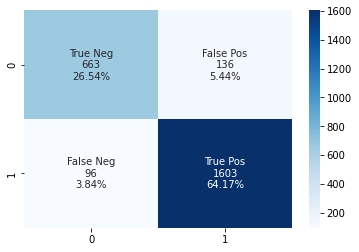

In [143]:
fans,ansprob = train_model(RandomForestClassifier(random_state=0),{'n_estimators': [50, 100, 200]})

In [144]:
ansprob

array([[0.83 , 0.17 ],
       [0.93 , 0.07 ],
       [0.81 , 0.19 ],
       ...,
       [0.445, 0.555],
       [0.105, 0.895],
       [0.2  , 0.8  ]])

For DecisionTreeClassifier


Best Parameters :  DecisionTreeClassifier(criterion='entropy', max_depth=6)


Accuracy : 0.8650920736589272


Precision Score :  0.8783333333333333


Recall Score :  0.9305473808122425


ROC AUC Score :  0.8282273825212653


Classification Report

               precision    recall  f1-score   support

         0.0       0.83      0.73      0.77       799
         1.0       0.88      0.93      0.90      1699

    accuracy                           0.87      2498
   macro avg       0.85      0.83      0.84      2498
weighted avg       0.86      0.87      0.86      2498



Confusion Matrix


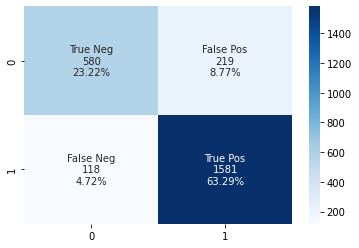

In [145]:
from sklearn.tree import DecisionTreeClassifier
fans1,ansprob1 = train_model(DecisionTreeClassifier(),{'max_depth': [1,2,3,4,5,6,7,8,9,10], 'criterion':['entropy']})

For LogisticRegression


Best Parameters :  LogisticRegression(C=10.0, max_iter=5000, random_state=123, solver='liblinear')


Accuracy : 0.8923138510808647


Precision Score :  0.906712172923777


Recall Score :  0.9381989405532666


ROC AUC Score :  0.8664711849199375


Classification Report

               precision    recall  f1-score   support

         0.0       0.86      0.79      0.83       799
         1.0       0.91      0.94      0.92      1699

    accuracy                           0.89      2498
   macro avg       0.88      0.87      0.87      2498
weighted avg       0.89      0.89      0.89      2498



Confusion Matrix


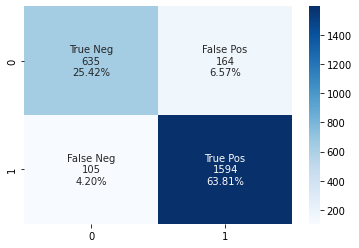

In [146]:
fans2,ansprob2 = train_model(LogisticRegression(random_state=123,solver='liblinear', penalty='l2', max_iter=5000),dict(C=np.logspace(1, 4, 10)))

In [147]:
ansprob1[:,1]

array([0.09628611, 0.05050505, 0.52755906, ..., 0.88385995, 0.9689243 ,
       0.88385995])

In [148]:
#results.target.value_counts()

In [149]:
import tensorflow as tf
from tensorflow.keras.regularizers import l2

In [150]:
X_train.shape

(9992, 36)

In [151]:
factor=0.0001
rate=0.4
model=tf.keras.models.Sequential([
                                  tf.keras.layers.Dense(160,input_shape=(36,),activation="relu",kernel_regularizer=l2(factor)),
                                  tf.keras.layers.Dropout(rate),
                                  tf.keras.layers.Dense(120,activation="relu",kernel_regularizer=l2(factor)),
                                  tf.keras.layers.Dropout(rate),
                                  tf.keras.layers.Dense(80,activation='relu',kernel_regularizer=l2(factor)),
                                  tf.keras.layers.Dropout(rate),
                                  tf.keras.layers.Dense(40,activation='relu',kernel_regularizer=l2(factor)),
                                  tf.keras.layers.Dropout(rate),
                                  tf.keras.layers.Dense(20,activation='relu',kernel_regularizer=l2(factor)),
                                  tf.keras.layers.Dropout(rate),
                                  tf.keras.layers.Dense(10,activation='relu',kernel_regularizer=l2(factor)),
                                  tf.keras.layers.Dropout(rate),
                                  tf.keras.layers.Dense(units=1, activation='sigmoid')])

2022-03-13 17:41:37.299756: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [152]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [153]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self,epoch,logs={}):
    if(logs.get("val_accuracy")>0.95):
      print("Reached the accuracy required (ie) 90%", logs)
      self.model.stop_training=True
callback=myCallback()

In [154]:
model.fit(X_train, y_train, batch_size = 256,verbose=0, epochs = 300, callbacks=[callback], validation_split=0.25)

2022-03-13 17:41:39.238364: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [155]:
model_predictions = model.predict(test_final_df)

In [156]:
len(model_predictions)

4790

In [157]:
#ID_column = test_features["index"]
#results = pd.concat([ID_column, pd.DataFrame(model_predictions)], axis=1)
#results.columns = ['index', 'target']
#results.to_csv("submission.csv",index = False)
#results.shape
#results



Accuracy : 0.8783026421136909


Precision Score :  0.8885793871866295


Recall Score :  0.9387875220718069


ROC AUC Score :  0.8442373154789573


Classification Report

               precision    recall  f1-score   support

         0.0       0.85      0.75      0.80       799
         1.0       0.89      0.94      0.91      1699

    accuracy                           0.88      2498
   macro avg       0.87      0.84      0.86      2498
weighted avg       0.88      0.88      0.88      2498



Confusion Matrix


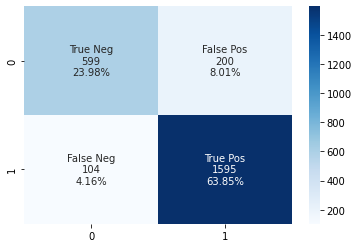

In [158]:
y_pred=model.predict(X_test)>0.5
metrics1(y_pred.astype(int),y_test)

In [159]:
ID_column = test_features["index"]
results = pd.concat([ID_column, pd.DataFrame(ansprob[:,1])], axis=1)
results.columns = ['index', 'target']
results.to_csv("submission1.csv",index = False)
results.shape
results

,index,target
0,16834,0.170
1,15437,0.070
2,8549,0.190
3,7222,0.075
4,17054,0.735
...,...,...
4785,5915,0.985
4786,11083,0.120
4787,2335,0.555
4788,7691,0.895


In [160]:
ansprob[:,1]

array([0.17 , 0.07 , 0.19 , ..., 0.555, 0.895, 0.8  ])